# Simulating the paired birth death process
Tim Tyree<br>
10.12.2022

In [1]:
from lib import *

In [2]:
from collections import deque


In [3]:
from scipy import stats
darkmode=False
if darkmode:
    # For darkmode plots
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
import warnings
warnings.simplefilter("ignore", UserWarning)
# import cupy as cp
np.random.seed(42)
# cp.random.seed(42)

In [31]:
plt.plot([1]*4)
plt.close()
#reset matplotlib
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

In [5]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
# %matplotlib notebook
%matplotlib inline

In [6]:
wjr=recall_powerlaw_fits_to_full_models()


In [7]:
#define token system parameters
num=4/3
nup=2/3
A=1.
Mp=1.
# mag_ratio=0.5 #minus divided by plus
# Mm=float(Mp * mag_ratio)
Mm=0.5
comp_Wp = get_comp_W(A,nup,Mp)
comp_Wm = get_comp_W(A,num,Mm)
Wp = njit(comp_Wp)
Wm = njit(comp_Wm)


In [8]:
#define time step, DT
# DT = 0.025
DT = 0.1#0.025
print(f"let {DT=} seconds.")
print(f"{np.sqrt((DT*512)**2*100)=}")
print(f"{np.log(128)/np.log(2)=}")
print(f"{np.sqrt(128/2)=}")
print(f"ooh... yes...")

let DT=0.1 seconds.
np.sqrt((DT*512)**2*100)=512.0
np.log(128)/np.log(2)=7.0
np.sqrt(128/2)=8.0
ooh... yes...


In [9]:
#compute the probability of upward/downward transition by powerlaw
#input: N, Wp, Wm
#output: real value between 0 and 1
#TODO: implement linked list bc it handles infinite spaces well.
#HINT: stackoverflow numpy linked list datatype

In [10]:
#set initial number of particles
@njit
def comp_first_passage_time_paired_bd_process(
        N=6,
        DT=0.1,
        random_state=42,
        max_num_steps=1000000,**kwargs):
    """
    Example Usage:
first_passage_time = comp_first_passage_time_paired_bd_process(N=6,
            random_state=42,max_num_steps=1000000)#,**kwargs)
    """
    np.random.seed(random_state)
    error_code=0
    assert N%2==0
    step=0
    dont_break=True
    while dont_break:
        #compute transition probabilities
        pup = Wp(N)*DT
        pum = Wm(N)*DT
        #randomly sample a value
        p = np.random.rand()
        #change depending on that value
        if p>pup:
            N+=2
        if p<pum:
            N-=2
        #i know edge case exists for ~1/2 of the sample in theory.
        #decide edge cases by predominance
        #by setting switch to go up instead of down when transition is otherwise undefined.
        #else, we'll keep to the default, wherein negative wins...
        if pum>pup:
            #closest one to half wins
            dpum=np.abs(0.5-pum)
            dpup=np.abs(0.5-pup)
            if dpup<dpum:
                #then for once, positive wins!
                if (p>pup) & (p<pum):
                    N+=2
        #break if not a particle exists
        if N<1:
            dont_break=False
        elif step>max_num_steps:
            dont_break=False
            error_code=1
        step+=1

    first_passage_time = step*DT
    return first_passage_time

__result:__ ^that is crazy-ass inefficient.  it didn't even finish after 10000002 time steps


In [11]:

random_state=42
max_num_steps=100000

np.random.seed(random_state)


# first_passage_time = comp_first_passage_time_paired_bd_process(N=6,DT=DT,
#                                             max_num_steps=1000000)
comp_first_passage_time_paired_bd_process(
        N=6,
        DT=0.1,
        random_state=43,
        max_num_steps=1000000)

# first_passage_time
#TODO: vectorize ^this
# first_passage_time = comp_first_passage_time_paired_bd_process(N=6,
#             random_state=42,max_num_steps=1000000)#,**kwargs)
# first_passage_time


240.9

In [12]:
#warning >5 min run time
# #simulate first passage times many times
# max_num_steps=1000000
# num_epochs=100
# DT=0.01
# seed=random_state
# N_values  = np.arange(2,80,2)
# zeroes_values = np.zeros_like(N_values)
# first_passage_time_values_lst = []
# for epoch in range(num_epochs):
#     first_passage_time_values = zeroes_values.copy()    
#     for i,N in enumerate(N_values):
#         first_passage_time_values[i]=comp_first_passage_time_paired_bd_process(
#                 N=N,DT=DT,random_state=seed*(epoch+1),max_num_steps=max_num_steps)
#     #record
#     first_passage_time_values_lst.append(first_passage_time_values.copy())
# #     first_passage_time_values_lst.append(first_passage_time_values)

In [15]:
# first_passage_time_values_lst[1]

In [697]:
# arr = np.stack(first_passage_time_values_lst)
# y_values = np.mean(arr,axis=0)
# plt.plot(N_values,y_values)

In [698]:
# #DONE: estimate the distribution of termination times
# arr[-1].shape

In [699]:
# arr[:,-1]

In [700]:
# fontsize=14
# bins=np.arange(4,20,0.2)
# fig,ax=plt.subplots()
# for i in range(10):
#     ax.hist(arr[:,i],bins=bins,label=i)
# format_plot(ax=ax,xlabel='x',ylabel='y',fontsize=fontsize)
# ax.legend(fontsize=fontsize,loc='upper right')
# plt.show()

In [701]:
# TODO: average ^this over the expected number of particles from the qs distrib

# scratchwerk

In [702]:
# #set initial number of particles
# N=6
# max_num_particles_init_over_2=512
# # Nmax=2*max_num_particles_init_over_2
# n_values = np.arange(max_num_particles_init_over_2)
# p_values = np.zeros(max_num_particles_init_over_2)
# # pin_values = np.zeros(max_num_particles_init_over_2)
# # pout_values = np.zeros(max_num_particles_init_over_2)
# p_values[n_values==N]=1.
# p_values_out=p_values.copy()

In [703]:
#TODO: dev deterministic one step method from the recurrance relation from the master equation
#input: Wp, Wm
#output: t_matrix = transition matrix for this linear system of ode's
#input: t_matrix,p_values
#output: number of steps until termination

# input_p_values=


In [704]:
# def comp_probability_current(N,N_values,P_values,Wp,Wm):
#     """returns the probability current in the paired birth-death process.
    
#     N_values is int array indexed by int N.  
#     P_values is a float array. 
#     Wp,Wm are real functions that return floats.
    
#     Example Usage:
# P_values=np.ones(N_values.shape[0])
# flux_in_hi , flux_in_lo , flux_out = comp_probability_current(N,N_values,P_values,Wp,Wm)
#     """
#     P = float(P_values[N==N_values])
#     Pp= float(P_values[N+2==N_values])
#     Pm= float(P_values[N-2==N_values])
#     flux_in_lo = Wp(N-2)*Pm 
#     flux_in_hi = Wm(N+2)*Pp 
#     flux_out= Wp(N)*P    + Wm(N)*P 
#     current = flux_in_hi + flux_in_lo - flux_out
#     return flux_in_hi , flux_in_lo , flux_out
#     #return current

# simulating the master equations

In [30]:
max_num_particles_init_over_2=512
max_num_particles_init_over_2=50
max_num_particles_init_over_2=200


In [31]:
# input_fn = search_for_file()
# input_fn

kwargs = dict(data_fk_dir=f'{nb_dir}/data/full_results/data_fig4_vidmar_fk_tt.csv',
              data_lr_dir=f'{nb_dir}/data/full_results/data_fig4_vidmar_lr_tt.csv',
             min_num_particles=9)
dict_wjr = recall_death_rates_vidmar_rappel(**kwargs)
fk=dict_wjr['fk'].sort_values(by='q')
lr=dict_wjr['lr'].sort_values(by='q')

# birth_rate_dir_fk = '/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/data_fig4_timothy_fk_up2_rescaled_per_tt.csv'
# birth_rate_dir_lr = '/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/data_fig4_timothy_lr_up2_rescaled_per_tt.csv'
birth_rate_dir_fk = '/Users/timothytyree/Documents/GitHub/bgmc/python/data/full_results/data_fig4_timothy_fk_up2_rescaled_per_tt.csv'
birth_rate_dir_lr = '/Users/timothytyree/Documents/GitHub/bgmc/python/data/full_results/data_fig4_timothy_lr_up2_rescaled_per_tt.csv'
# death_rate_dir_fk = '/Users/timothytyree/Documents/GitHub/bgmc/python/data/full_results/data_fig4_vidmar_fk_rescaled_rates.csv'
# death_rate_dir_lr = '/Users/timothytyree/Documents/GitHub/bgmc/python/data/full_results/data_fig4_vidmar_lr_rescaled_rates.csv'
# df_death = pd.read_csv(death_rate_dir_fk)
df_birth_fk = pd.read_csv(birth_rate_dir_fk)
# df_death = pd.read_csv(death_rate_dir_lr)
df_birth_lr = pd.read_csv(birth_rate_dir_lr)

#scale from kHz to Hz
df_birth_fk['w']*=1e3
df_birth_lr['w']*=1e3

# DONE: compute powerlaw fits of birth rates wjr
dict_fit_birth_fk = print_fit_power_law(x=df_birth_fk['q'].values,y=df_birth_fk['w'].values)
dict_fit_birth_lr = print_fit_power_law(x=df_birth_lr['q'].values,y=df_birth_lr['w'].values)

print(f"\nwjr['fk_pbc']:")
print_dict(wjr['fk_pbc'])
print(f"\nwjr['lr_pbc']:")
print_dict(wjr['lr_pbc'])

print(f"\nwjr['fk_pbc']:")
print_dict(wjr['fk_pbc'])
print(f"\nwjr['lr_pbc']:")
print_dict(wjr['lr_pbc'])


#DONE: get token inputs prepared
dict_fit_death_lr = dict(wjr['lr_pbc'])
dict_fit_death_fk = dict(wjr['fk_pbc'])
Mp = dict_fit_birth_fk['M']
nup = dict_fit_birth_fk['m']
Mm = dict_fit_death_fk['M']
num = dict_fit_death_fk['m']
model_name='Fenton-Karma'

# Mp = dict_fit_birth_lr['M']
# nup = dict_fit_birth_lr['m']
# Mm = dict_fit_death_lr['M']
# num = dict_fit_death_lr['m']
# model_name='Luo-Rudy'

m = 0.229594 +/- 0.010098
M = 0.864210 +/- 0.002349 Hz/cm^2; B=0.529597 +/- 0.020570
RMSE=0.0215 Hz/cm^2; R^2=0.9655; MPE=3.0209%; N=73
m = 0.714755 +/- 0.009768
M = 3.277073 +/- 0.102643 Hz/cm^2; B=5.262676 +/- 0.107278
RMSE=0.0417 Hz/cm^2; R^2=0.9971; MPE=4.2323%; N=62

wjr['fk_pbc']:
m=1.8772341309722325
Delta_m=0.02498750277237229
M=5.572315674840435
Delta_M=0.3053120355191732
b=1.665608066257863
Delta_b=0.029341409948945123

wjr['lr_pbc']:
m=1.6375562704001745
Delta_m=0.017190912126700632
M=16.73559858353835
Delta_M=0.8465090320196467
b=2.86877101880514
Delta_b=0.0311865277365552

wjr['fk_pbc']:
m=1.8772341309722325
Delta_m=0.02498750277237229
M=5.572315674840435
Delta_M=0.3053120355191732
b=1.665608066257863
Delta_b=0.029341409948945123

wjr['lr_pbc']:
m=1.6375562704001745
Delta_m=0.017190912126700632
M=16.73559858353835
Delta_M=0.8465090320196467
b=2.86877101880514
Delta_b=0.0311865277365552


In [32]:
#TODO: compute the eigenvalues of the transition matrix
#TODO: compute the fraction terminated time trace initializing at the quasistatic distribution
#estimate the quasistatic distribution
L=5 #cm
A=L**2
num_iter=20

#TODO: recall the powerlaw fits to the FK model 
#heretim

# Wp = get_comp_W(A,nup,Mp)
# Wm = get_comp_W(A,num,Mm)
comp_Wp = get_comp_W(A,nup,Mp)
comp_Wm = get_comp_W(A,num,Mm)
Wp = njit(comp_Wp)
Wm = njit(comp_Wm)

# n_qs,prob_qs = comp_quasistatic_distrib_paired_bdrates(comp_Wm,comp_Wp,num_iter=num_iter,freq_prev=1.)
n_qs,prob_qs = comp_quasistatic_distrib_paired_bdrates(Wm,Wp,num_iter=num_iter,freq_prev=100.)

In [33]:
# DT=0.01
# DT=0.0025
# DT=0.0000025 #stable at N=Nmax measurement as initial condition
DT=0.000025 #stable?
dim=max_num_particles_init_over_2
#precompute the transition matrix
N_values = 2*(1+np.arange(dim))
t_matrix=np.zeros((dim,dim))
for i,N in enumerate(N_values):
    flux_in_lo = Wp(N-2)
    flux_in_hi = Wm(N+2)
    flux_out= Wp(N) + Wm(N)
    t_matrix[i,i]-=flux_out
    t_matrix[i,i-1]+=flux_in_lo
    if i+1<dim:
        t_matrix[i,i+1]+=flux_in_hi
#     else:
#         #TODO: implement reflecting boundary conditions at the high particle number cutoff
#         #heretim
# #         t_matrix[i+1,i+1]+=flux_in_hi # is it that simple?
#         t_matrix[i,i]+=flux_in_hi # is it that simple?
        
t_matrix[0,0] = -(Wm(2)+Wp(2)) # from N=2
t_matrix[0,1] = Wm(4) # from N=4

#reflecting bc at end
Nmax=int(N_values[-1])
# t_matrix[-1,-1] = -(Wm(Nmax)) #-(Wm(Nmax)+Wp(Nmax)) 
t_matrix[-1,-1] = -Wm(Nmax) #-(Wm(Nmax)+Wp(Nmax)) 
t_matrix[-1,-2] = Wp(Nmax-2) 

t_matrix*=DT #transfer func is now in dimensionless units 

#DONT: #transpose
# t_matrix = t_matrix.T.copy()

In [34]:
# num_iter=int(Nmax/2)
N_qs,P_qs = comp_quasistatic_distrib_paired_bdrates(Wm,Wp,num_iter=dim,freq_prev=1.)
# P_qs/=np.sum(P_qs) #normalize for 1.0000000000000002 floating point arith error
# assert np.sum(P_qs)==1
P_qs.shape,np.sum(P_qs)

((200,), 1.0000000000000002)

In [48]:
num_steps=100000
save_every=1000
# num_steps=int(1e8)
# save_every=10000
# num_steps=int(1e6)  #gives a perfect exponential curve in <60 seconds
#TODO: use  ^this 1e6 time steps to deduce the 
# functional dependence / gradients of nup,num,Mp,Mm evaluated at the full models

#implement the absorbing boundary condition at N=0
#TODO: do a basic numerical test case using an initial state measured to be at N=2.
# P_values = np.zeros(dim)
# P_values[0]=1. #measured to be at N=2.
# P_values[-1]=1. #measured to be at N=Nmax.
P_values=P_qs.copy()
print(f"{sum(P_values)=}")
# P_net_values = np.zeros(num_steps)-9999.
P_net_lst=[]
step_lst=[]
for step in range(num_steps):
    # dP_values=np.dot(t_matrix,P_values)
    P_values+=np.dot(t_matrix,P_values)#dP_values
    if step%save_every==0:
        P_net = np.sum(P_values)
        #record
        P_net_lst.append(P_net)
        step_lst.append(step)
    #P_net_values[step]=P_net
print(f"{sum(P_values)=}")
P_net_values=np.array(P_net_lst)
t_values=np.array(step_lst)*DT #seconds
# t_values=np.arange(num_steps)*DT #seconds

sum(P_values)=1.0000000000000004
sum(P_values)=0.8443886393863168


In [49]:
beep(3)

-n 
-n 
-n 


0

In [50]:
#TODO: implement the IMR using the iterative method

__Result__ all eigen values are strictly negative, supporting the existence of a rate limiting step that sets and the effective time scale for an exponential distribution of termination times.

- TODO: plug ^that into letter and let them challenge me, bruh.

/Users/timothytyree/opt/miniconda3/envs/pyenv/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


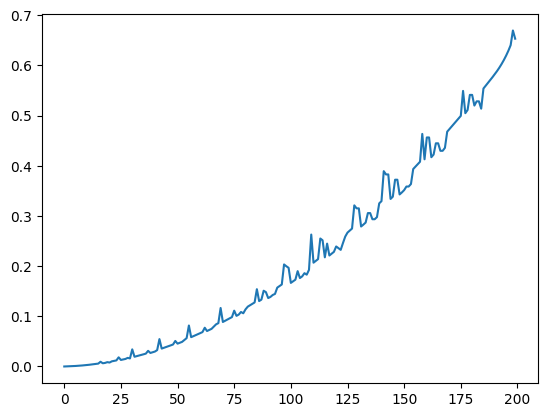

In [51]:
plt.plot(np.linalg.eigvals(-t_matrix))
# format_plot(use_loglog=True)
plt.show()

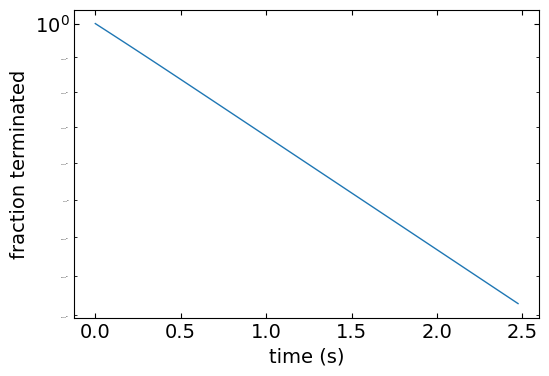

In [52]:
fig,ax=plt.subplots(figsize=(6,4))
ax.plot(t_values,P_net_values,lw=1)
# ax.plot(t_values,P_net_values,lw=1)
# ax.set_xlim([DT/2,1.1])
# ax.set_ylim([0.001,1])
# ax.set_xscale('log')
ax.set_yscale('log')
format_plot(ax=ax,xlabel='time (s)',ylabel='fraction terminated',fontsize=14)
ax.tick_params(top=True, right=True,direction='in',which='both')
plt.show()

In [53]:
A

25

<AxesSubplot:>

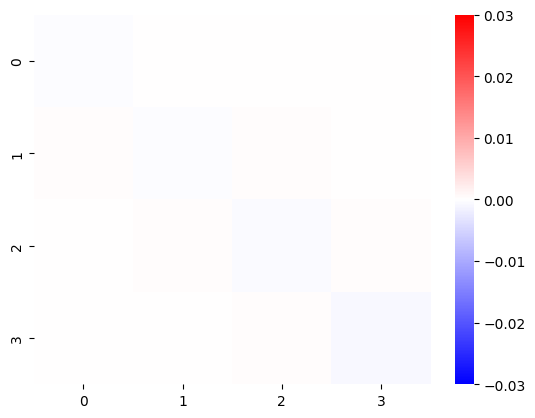

In [54]:
#heretim
#TODO: do a basic numerical test case using quasistatic distribution
#
sns.heatmap(t_matrix[:4,:4],vmin=-.03,vmax=.03,cmap='bwr')

<AxesSubplot:>

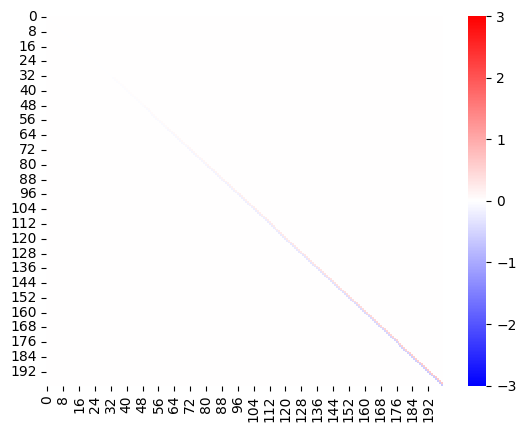

In [55]:
sns.heatmap(t_matrix,vmin=-3,vmax=3,cmap='bwr')

In [ ]:
dp_values =  #dpdt
dp_values*=DT

In [367]:
Wp,Wm

(CPUDispatcher(<function get_comp_W.<locals>.comp_W at 0x7fdcf974eaf0>),
 CPUDispatcher(<function get_comp_W.<locals>.comp_W at 0x7fdcf974e940>))

In [153]:
#TODO: dev one step method from the recurrance relation from the master equation
#HINT: i can copy stuff from the quasistatic solution 
# if i don't want to transcribe my easily accessible notes from this afternoon.
#TODO: compute transition from lo to hi
#TODO: compute transition from hi to lo
#TODO: format this as a matrix
#TODO: multiply by the transition matrix until  

In [55]:
#TODO: compute thresholds lo and hi given N

In [369]:
# pthresh_lo=?

In [368]:
# pthresh_hi=?

In [56]:
dim=max_num_particles_init_over_2
t_matrix=np.zeros((dim,dim))
l_matrix=np.zeros((dim,dim))
i_matrix=np.eye(dim)
for i in range(dim):
    im=i-1
    #im=i+1
    for j in range(dim):
        if im==j:
            l_matrix[i,j]=1
# i_matrix      
l_matrix.T

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [370]:
# #TODO: derive the rate of growth/decay at each n value
# N=6
# random_state=42
# assert N%2==0
# np.random.seed(random_state)
# p = np.random.rand()
# if p<pthresh_lo:
#     print(f"oh oh! lo fo sho!")
# if p<pthresh_hi:
#     print(f"he hi! wanna come by!?")

In [365]:

# # p_deque = deque(np.array(list(range(max_num_particles_init_over_2))))
# # p_deque = deque(np.array(list(range(max_num_particles_init_over_2))))
# n_deque = deque(np.arange(1,N+1))
# p_deque = deque([0.*x for x in n_deque])
# n_deque.
# d = deque([1,2,3,4])

# # # print d
# # for x in d:
# #     print x
# # # print d.pop(), d

# fit powerlaws to birth/death rates

In [12]:
# input_fn = search_for_file()
# input_fn
kwargs = dict(data_fk_dir=f'{nb_dir}/data/full_results/data_fig4_vidmar_fk_tt.csv',
              data_lr_dir=f'{nb_dir}/data/full_results/data_fig4_vidmar_lr_tt.csv',
             min_num_particles=9)
dict_wjr = recall_death_rates_vidmar_rappel(**kwargs)
fk=dict_wjr['fk'].sort_values(by='q')
lr=dict_wjr['lr'].sort_values(by='q')


In [13]:
nb_dir

'/home/timothytyree/Documents/GitHub/bgmc/python'

In [14]:
# birth_rate_dir_fk = '/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/data_fig4_timothy_fk_up2_rescaled_per_tt.csv'
# birth_rate_dir_lr = '/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/data_fig4_timothy_lr_up2_rescaled_per_tt.csv'
birth_rate_dir_fk = f'{nb_dir}//data/full_results/data_fig4_timothy_fk_up2_rescaled_per_tt.csv'
birth_rate_dir_lr = f'{nb_dir}//data/full_results/data_fig4_timothy_lr_up2_rescaled_per_tt.csv'
# death_rate_dir_fk = '/Users/timothytyree/Documents/GitHub/bgmc/python/data/full_results/data_fig4_vidmar_fk_rescaled_rates.csv'
# death_rate_dir_lr = '/Users/timothytyree/Documents/GitHub/bgmc/python/data/full_results/data_fig4_vidmar_lr_rescaled_rates.csv'
# df_death = pd.read_csv(death_rate_dir_fk)
df_birth_fk = pd.read_csv(birth_rate_dir_fk)
# df_death = pd.read_csv(death_rate_dir_lr)
df_birth_lr = pd.read_csv(birth_rate_dir_lr)

#scale from kHz to Hz
df_birth_fk['w']*=1e3
df_birth_lr['w']*=1e3

In [15]:
# DONE: compute powerlaw fits of birth rates wjr
dict_fit_birth_fk = print_fit_power_law(x=df_birth_fk['q'].values,y=df_birth_fk['w'].values)
dict_fit_birth_lr = print_fit_power_law(x=df_birth_lr['q'].values,y=df_birth_lr['w'].values)

print(f"\nwjr['fk_pbc']:")
print_dict(wjr['fk_pbc'])
print(f"\nwjr['lr_pbc']:")
print_dict(wjr['lr_pbc'])

print(f"\nwjr['fk_pbc']:")
print_dict(wjr['fk_pbc'])
print(f"\nwjr['lr_pbc']:")
print_dict(wjr['lr_pbc'])

m = 0.229594 +/- 0.010098
M = 0.864210 +/- 0.002349 Hz/cm^2; B=0.529597 +/- 0.020570
RMSE=0.0215 Hz/cm^2; R^2=0.9655; MPE=3.0209%; N=73
m = 0.714755 +/- 0.009768
M = 3.277073 +/- 0.102643 Hz/cm^2; B=5.262676 +/- 0.107278
RMSE=0.0417 Hz/cm^2; R^2=0.9971; MPE=4.2323%; N=62

wjr['fk_pbc']:
m=1.8772341309722325
Delta_m=0.02498750277237229
M=5.572315674840435
Delta_M=0.3053120355191732
b=1.665608066257863
Delta_b=0.029341409948945123

wjr['lr_pbc']:
m=1.6375562704001745
Delta_m=0.017190912126700632
M=16.73559858353835
Delta_M=0.8465090320196467
b=2.86877101880514
Delta_b=0.0311865277365552

wjr['fk_pbc']:
m=1.8772341309722325
Delta_m=0.02498750277237229
M=5.572315674840435
Delta_M=0.3053120355191732
b=1.665608066257863
Delta_b=0.029341409948945123

wjr['lr_pbc']:
m=1.6375562704001745
Delta_m=0.017190912126700632
M=16.73559858353835
Delta_M=0.8465090320196467
b=2.86877101880514
Delta_b=0.0311865277365552


In [16]:
xv = np.arange(0.02, 1,0.01)
# evaluate powerlaw fits of birth rates wjr
yv_birth_lr = dict_fit_birth_lr['M']*xv**dict_fit_birth_lr['m']
yv_death_lr = wjr['lr_pbc']['M']*xv**wjr['lr_pbc']['m']
# evalutate plot powerlaw fits of death rates wjr
yv_birth_fk = dict_fit_birth_fk['M']*xv**dict_fit_birth_fk['m']
yv_death_fk = wjr['fk_pbc']['M']*xv**wjr['fk_pbc']['m']
# yv_birth_lr.shape,yv_birth_fk.shape

#compute the intersection point for both of the full models
index_fk = np.argmin(np.exp(np.log(yv_birth_fk/yv_death_fk)**2))
qstar_fk = xv[index_fk]
wstar_fk = yv_birth_fk[index_fk]
# index_lr = np.argmin(np.log(yv_birth_lr/yv_death_lr)**2)
index_lr = np.argmin(np.exp(np.log(yv_birth_lr/yv_death_lr)**2))
qstar_lr = xv[index_lr]
wstar_lr = yv_birth_lr[index_lr]
qstar_lr

0.16999999999999996

In [17]:
# plt.plot(xv,(yv_birth_lr-yv_death_lr)**2)
# plt.show()
qstar_fk,qstar_lr

(0.31999999999999995, 0.16999999999999996)

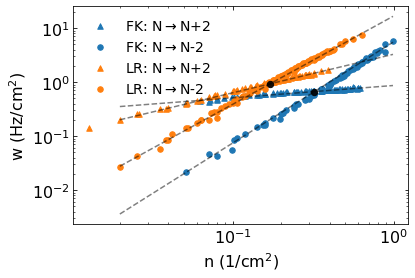

In [18]:
# fig,ax=plt.subplots()
fig,ax=plt.subplots(figsize=(6,4))
fontsize=16
# fontsize=20
alpha=0.9

# df_birth_fk.plot(x='q',y='w',ax=ax,c='C0',alpha=0.5,label=r'FK: N$\rightarrow$N+2',lw=4)
# fk.plot(x='q',y='w',ax=ax,c='C0',label=r'FK: N$\rightarrow$N-2',lw=4)
# df_birth_lr.plot(x='q',y='w',ax=ax,c='C1',alpha=0.5,label=r'LR: N$\rightarrow$N+2',lw=4)
# lr.plot(x='q',y='w',ax=ax,c='C1',label=r'LR: N$\rightarrow$N-2',lw=4)
markersize=30
df_birth_fk.plot.scatter(x='q',y='w',ax=ax,c='C0',#'gray',#
                         marker='^',
                         alpha=1.,label=r'FK: N$\rightarrow$N+2',s=markersize)
fk.plot.scatter(x='q',y='w',ax=ax,c='C0',label=r'FK: N$\rightarrow$N-2',s=markersize)
df_birth_lr.plot.scatter(x='q',y='w',ax=ax,c='C1',#'r',#
                        marker='^',
                         alpha=1.,label=r'LR: N$\rightarrow$N+2',s=markersize)
lr.plot.scatter(x='q',y='w',ax=ax,c='C1',label=r'LR: N$\rightarrow$N-2',s=markersize)


#plot the powerlaw fits
ax.plot(xv,yv_death_fk,'k--',alpha=0.5)
ax.plot(xv,yv_death_lr,'k--',alpha=0.5)
ax.plot(xv,yv_birth_fk,'k--',alpha=0.5)
ax.plot(xv,yv_birth_lr,'k--',alpha=0.5)

#draw vertical dotted line up to the intersection point for both of the full models
ax.scatter([qstar_fk],[wstar_fk],c='k',s=40,alpha=0.9,zorder=100)
ax.scatter([qstar_lr],[wstar_lr],c='k',s=40,alpha=0.9,zorder=100)
# ax.plot([qstar_fk,qstar_fk],[0.001,wstar_fk],'k:',alpha=0.9)
# ax.plot([qstar_lr,qstar_lr],[0.001,wstar_lr],'k:',alpha=0.9)


# format_plot
format_plot(ax=ax,xlabel=r'n (1/cm$^2$)',ylabel=r'w (Hz/cm$^2$)',fontsize=fontsize)#,use_loglog=True)
# format_plot(ax=ax,xlabel=r'q (1/cm$^2$)',ylabel=r'w (Hz/cm$^2$)',fontsize=fontsize)#,use_loglog=True)
# plt.legend(fontsize=16,frameon=False,loc='upper left')
plt.legend(fontsize=14,frameon=False,loc='upper left')
# AddLegend(loc='upper left')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim((0.0023641776732192935, 25.08908114695242))
ax.tick_params(top=True, right=True,direction='in',which='both')

plt.show()

In [192]:
# from inspect import getsource

In [195]:
# # print(getsource(format_plot))
# np.diag?

# analytical check: test whether tau(N_0) increases exponentially with A

We have an expressions for $\tau(N)$ in terms of the action variable, $\phi$:
 
$$
\tau(N) = \sum_{k=1}^{N/2} \phi(2(k-1)) \sum_{j=k}^\infty \frac{1}{\phi(2j)W_{+2}(2j)},
$$
and 
$$
\phi(k) = \Pi_{i=1}^{k/2} \frac{W_{-2}(2i)}{W_{+2}(2i)}.
$$

Given the mean termination time conditioned on $N$ particles existing, we estimate the mean termination time according to:
$$
\mathbb{E}[\tau] = \sum_{N=0}^\infty \tau(N) P(N)
$$
Where $P(N)$ is the quasistatic distribution.


In [19]:
#DONE: get token inputs prepared
dict_fit_death_lr = dict(wjr['lr_pbc'])
dict_fit_death_fk = dict(wjr['fk_pbc'])
Mp = dict_fit_birth_fk['M']
nup = dict_fit_birth_fk['m']
Mm = dict_fit_death_fk['M']
num = dict_fit_death_fk['m']
model_name='Fenton-Karma'

# Mp = dict_fit_birth_lr['M']
# nup = dict_fit_birth_lr['m']
# Mm = dict_fit_death_lr['M']
# num = dict_fit_death_lr['m']
# model_name='Luo-Rudy'

In [20]:
print(f"universal inputs")
print(f"{Mp=}; {nup=}")
print(f"{Mm=}; {num=}")

xv = np.arange(0.02, 1,0.01)
qstar,wstar = comp_powerlaw_intersection(Mp,nup,Mm,num,xv=xv)
print(f"--> {qstar=:.4f}; {wstar=:.4f}")

universal inputs
Mp=0.8642103569057054; nup=0.22959399086621063
Mm=5.572315674840435; num=1.8772341309722325
--> qstar=0.3200; wstar=0.6653


In [21]:
# A_values = np.arange(5,100,1)
A_values = np.arange(5,400,5)
# A_values = np.arange(10,1000,5)
N0_values = np.arange(2,12,2)
# N0_values = np.arange(2,40,2)
# maxinf_num_inner_sum=20 # high particle number cutoff
# maxinf_num_inner_sum=np.max(N0_values)+10 # high particle number cutoff
# maxinf_num_inner_sum=np.max(N0_values)+10 # high particle number cutoff
maxinf_num_inner_sum=100 # high particle number cutoff

dict_tau_lst=[]
for A in A_values:
    comp_Wp = get_comp_W(A,nup,Mp)
    comp_Wm = get_comp_W(A,num,Mm)
#     comp_Wp = njit(get_comp_W(A,nup,Mp))
#     comp_Wm = njit(get_comp_W(A,num,Mm))
    phi = get_phi(comp_Wm,comp_Wp)
    eval_tau= get_eval_tau(eval_tau_expression)
#     #compute average over initial values
#     n_qs,prob_qs = comp_quasistatic_distrib_paired_bdrates(comp_Wm,comp_Wp,num_iter=20)
#     taubar = eval_tau(n_qs, prob_qs, phi, comp_Wm, comp_Wp, printing=False,**kwargs)
    Nbar = qstar*A

    for N0 in N0_values:
        tau = eval_tau_expression(n_over_2 = int(np.floor(N0/2)),phi=phi, comp_Wm=comp_Wm, comp_Wp=comp_Wp, maxinf_num_inner_sum=maxinf_num_inner_sum,printing=False)
#         tau = eval_tau_expression(n_over_2 = int(np.floor(N0/2)),phi=phi, comp_Wm=comp_Wm, comp_Wp=comp_Wp, maxinf_num_inner_sum=int(Nbar)+2,printing=False)
        #record
        dict_tau_lst.append(dict(
            A=A,
            N0=N0,
            tau=tau,
#             taubar=taubar,
            Nbar=Nbar,
        ))
df_tau = pd.DataFrame(dict_tau_lst)
df_tau.head()

,A,N0,tau,Nbar
0,5,2,0.243042,1.6
1,5,4,0.285628,1.6
2,5,6,0.291738,1.6
3,5,8,0.293527,1.6
4,5,10,0.294251,1.6


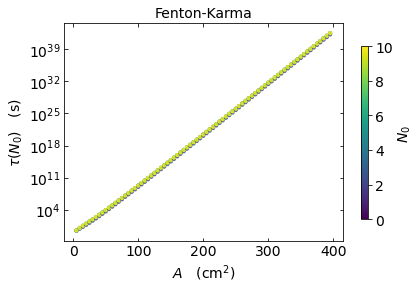

In [22]:
#basic scatter plot of the data
figsize=(5,4)
cmap='viridis'
vmin=0
vmax=np.max(N0_values)
fontsize=14
fig,ax=plt.subplots(figsize=figsize)
#plot data
df_tau.plot.scatter(x='A',y='tau',c='N0',s=10,alpha=0.7,
                    cmap=cmap,ax=ax,vmin=vmin,vmax=vmax,colorbar=False)
    
#add colorbar
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
# norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
cmap_obj = mpl.cm.get_cmap(cmap)
cax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
cb = mpl.colorbar.ColorbarBase(cax,
                               cmap=cmap_obj,
                               norm=norm,
                               spacing='proportional')
cb.set_label(r'$N_0$', fontsize=fontsize)
cb.ax.tick_params(labelsize=fontsize)
ax.tick_params(top=True, right=True,direction='in',which='both')

# format_plot
format_plot(ax=ax,xlabel=r'$A$   (cm$^2$)',ylabel=r'$\tau(N_0)$   (s)',fontsize=fontsize)
ax.set_title(model_name,fontsize=fontsize)
ax.set_yscale('log')
# plt.tight_layout()
plt.show()

# TODO(later): search for universal relations involving tau(N_0) and A

In [23]:
groups = df_tau.groupby(by='N0')

In [24]:

#
#define xy columns
df_tau['x'] = df_tau['A']
df_tau['y'] = df_tau['tau']
#TODO: extract xy values
for N0,g in df_tau.groupby(by='N0'):
    pass
x_values = g['A'].values #A
# x_values = N0/g['A'].values #q


# plot $\tau(N_0)$ versus $A$ for both the full models

In [25]:
N0_values = np.arange(2,12,2)
# N0_values = np.arange(2,40,2)
N0_values = np.array([2,20])
N0_values

array([ 2, 20])

In [26]:
np.floor(20/2),np.floor(2/2)

(10.0, 1.0)

In [27]:
#DONE: get token inputs prepared
dict_fit_death_lr = dict(wjr['lr_pbc'])
dict_fit_death_fk = dict(wjr['fk_pbc'])
Mp = dict_fit_birth_fk['M']
nup = dict_fit_birth_fk['m']
Mm = dict_fit_death_fk['M']
num = dict_fit_death_fk['m']
model_name='Fenton-Karma'

# Mp = dict_fit_birth_lr['M']
# nup = dict_fit_birth_lr['m']
# Mm = dict_fit_death_lr['M']
# num = dict_fit_death_lr['m']
# model_name='Luo-Rudy'

print(f"universal inputs")
print(f"{Mp=}; {nup=}")
print(f"{Mm=}; {num=}")

xv = np.arange(0.02, 1,0.01)
qstar,wstar = comp_powerlaw_intersection(Mp,nup,Mm,num,xv=xv)
print(f"--> {qstar=:.4f}; {wstar=:.4f}")

# A_values = np.arange(5,100,1)
A_values = np.arange(5,400,5)
# A_values = np.arange(10,1000,5)
# N0_values = np.arange(2,12,2)
# # N0_values = np.arange(2,40,2)
# maxinf_num_inner_sum=20 # high particle number cutoff
# maxinf_num_inner_sum=np.max(N0_values)+10 # high particle number cutoff
# maxinf_num_inner_sum=np.max(N0_values)+10 # high particle number cutoff
maxinf_num_inner_sum=100 # high particle number cutoff

dict_tau_lst=[]
for A in A_values:
    comp_Wp = get_comp_W(A,nup,Mp)
    comp_Wm = get_comp_W(A,num,Mm)
#     comp_Wp = njit(get_comp_W(A,nup,Mp))
#     comp_Wm = njit(get_comp_W(A,num,Mm))
    phi = get_phi(comp_Wm,comp_Wp)
    eval_tau= get_eval_tau(eval_tau_expression)
#     #compute average over initial values
#     n_qs,prob_qs = comp_quasistatic_distrib_paired_bdrates(comp_Wm,comp_Wp,num_iter=20)
#     taubar = eval_tau(n_qs, prob_qs, phi, comp_Wm, comp_Wp, printing=False,**kwargs)
    Nbar = qstar*A

    for N0 in N0_values:
        tau = eval_tau_expression(n_over_2 = int(np.floor(N0/2)),phi=phi, comp_Wm=comp_Wm, comp_Wp=comp_Wp, maxinf_num_inner_sum=maxinf_num_inner_sum,printing=False)
#         tau = eval_tau_expression(n_over_2 = int(np.floor(N0/2)),phi=phi, comp_Wm=comp_Wm, comp_Wp=comp_Wp, maxinf_num_inner_sum=int(Nbar)+2,printing=False)
        #record
        dict_tau_lst.append(dict(
            A=A,
            N0=N0,
            tau=tau,
#             taubar=taubar,
            Nbar=Nbar,
        ))
df_tau = pd.DataFrame(dict_tau_lst)
df_tau_fk = df_tau.copy()

universal inputs
Mp=0.8642103569057054; nup=0.22959399086621063
Mm=5.572315674840435; num=1.8772341309722325
--> qstar=0.3200; wstar=0.6653


In [28]:
#DONE: get token inputs prepared
# dict_fit_death_lr = dict(wjr['lr_pbc'])
# dict_fit_death_fk = dict(wjr['fk_pbc'])
# Mp = dict_fit_birth_fk['M']
# nup = dict_fit_birth_fk['m']
# Mm = dict_fit_death_fk['M']
# num = dict_fit_death_fk['m']
# model_name='Fenton-Karma'

Mp = dict_fit_birth_lr['M']
nup = dict_fit_birth_lr['m']
Mm = dict_fit_death_lr['M']
num = dict_fit_death_lr['m']
model_name='Luo-Rudy'

print(f"universal inputs")
print(f"{Mp=}; {nup=}")
print(f"{Mm=}; {num=}")

xv = np.arange(0.02, 1,0.01)
qstar,wstar = comp_powerlaw_intersection(Mp,nup,Mm,num,xv=xv)
print(f"--> {qstar=:.4f}; {wstar=:.4f}")

# A_values = np.arange(5,100,1)
A_values = np.arange(5,400,5)
# A_values = np.arange(10,1000,5)
# N0_values = np.arange(2,12,2)
# # N0_values = np.arange(2,40,2)
# maxinf_num_inner_sum=20 # high particle number cutoff
# maxinf_num_inner_sum=np.max(N0_values)+10 # high particle number cutoff
# maxinf_num_inner_sum=np.max(N0_values)+10 # high particle number cutoff
maxinf_num_inner_sum=100 # high particle number cutoff

dict_tau_lst=[]
for A in A_values:
    comp_Wp = get_comp_W(A,nup,Mp)
    comp_Wm = get_comp_W(A,num,Mm)
#     comp_Wp = njit(get_comp_W(A,nup,Mp))
#     comp_Wm = njit(get_comp_W(A,num,Mm))
    phi = get_phi(comp_Wm,comp_Wp)
    eval_tau= get_eval_tau(eval_tau_expression)
#     #compute average over initial values
#     n_qs,prob_qs = comp_quasistatic_distrib_paired_bdrates(comp_Wm,comp_Wp,num_iter=20)
#     taubar = eval_tau(n_qs, prob_qs, phi, comp_Wm, comp_Wp, printing=False,**kwargs)
    Nbar = qstar*A

    for N0 in N0_values:
        tau = eval_tau_expression(n_over_2 = int(np.floor(N0/2)),phi=phi, comp_Wm=comp_Wm, comp_Wp=comp_Wp, maxinf_num_inner_sum=maxinf_num_inner_sum,printing=False)
#         tau = eval_tau_expression(n_over_2 = int(np.floor(N0/2)),phi=phi, comp_Wm=comp_Wm, comp_Wp=comp_Wp, maxinf_num_inner_sum=int(Nbar)+2,printing=False)
        #record
        dict_tau_lst.append(dict(
            A=A,
            N0=N0,
            tau=tau,
#             taubar=taubar,
            Nbar=Nbar,
        ))
df_tau = pd.DataFrame(dict_tau_lst)
df_tau_lr = df_tau.copy()

universal inputs
Mp=3.2770725040489235; nup=0.7147550082416185
Mm=16.73559858353835; num=1.6375562704001745
--> qstar=0.1700; wstar=0.9235


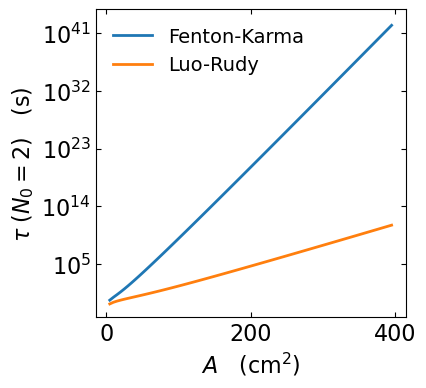

In [42]:
#basic scatter plot of the data at N_0 fixed
N0 = 2
# N0 = 20
# xlim
figsize=(4,4)
fontsize=16
markersize=10
alpha=1.0
ylim = (0.0005007487135910895, 5.156057164412211e+44)
# ylim=0.0005,100
# xlim=1,20

# alpha=0.7
fig,ax=plt.subplots(figsize=figsize)
#plot data
# df_tau_fk[df_tau_fk['N0']==N0].plot.scatter(x='A',y='tau',s=markersize,alpha=alpha,ax=ax,label='Fenton-Karma',color='C0')
# df_tau_lr[df_tau_lr['N0']==N0].plot.scatter(x='A',y='tau',s=markersize,alpha=alpha,ax=ax,label='Luo-Rudy',color='C1')
df_tau_fk[df_tau_fk['N0']==N0].plot(x='A',y='tau',alpha=alpha,ax=ax,label='Fenton-Karma',color='C0',lw=2)
df_tau_lr[df_tau_lr['N0']==N0].plot(x='A',y='tau',alpha=alpha,ax=ax,label='Luo-Rudy',color='C1',lw=2)
    
# format_plot
# format_plot(ax=ax,xlabel=r'$A$   (cm$^2$)',ylabel=r'$\tau(N_0)$   (s)',fontsize=fontsize)
format_plot(ax=ax,xlabel=r'$A$   (cm$^2$)',ylabel=r'$\tau\;$($N_0=$'+f'{N0})   (s)',fontsize=fontsize)
# ax.set_title(model_name,fontsize=fontsize)
ax.set_yscale('log')
# plt.tight_layout()
ax.tick_params(top=True, right=True,direction='in',which='both')
ax.legend(fontsize=fontsize-2,frameon=False,loc='upper left')
# ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.show()

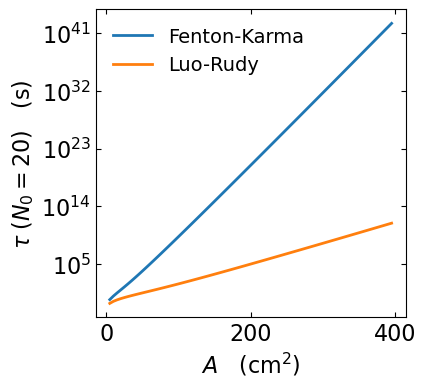

In [43]:
#basic scatter plot of the data at N_0 fixed
# N0 = 2
N0 = 20
# xlim
figsize=(4,4)
fontsize=16
markersize=10
alpha=1.0
# ylim = (0.0005007487135910895, 5.156057164412211e+44)
# alpha=0.7
fig,ax=plt.subplots(figsize=figsize)
#plot data
# df_tau_fk[df_tau_fk['N0']==N0].plot.scatter(x='A',y='tau',s=markersize,alpha=alpha,ax=ax,label='Fenton-Karma',color='C0')
# df_tau_lr[df_tau_lr['N0']==N0].plot.scatter(x='A',y='tau',s=markersize,alpha=alpha,ax=ax,label='Luo-Rudy',color='C1')
df_tau_fk[df_tau_fk['N0']==N0].plot(x='A',y='tau',alpha=alpha,ax=ax,label='Fenton-Karma',color='C0',lw=2)
df_tau_lr[df_tau_lr['N0']==N0].plot(x='A',y='tau',alpha=alpha,ax=ax,label='Luo-Rudy',color='C1',lw=2)
    
# format_plot
# format_plot(ax=ax,xlabel=r'$A$   (cm$^2$)',ylabel=r'$\tau(N_0)$   (s)',fontsize=fontsize)
format_plot(ax=ax,xlabel=r'$A$   (cm$^2$)',ylabel=r'$\tau\;$($N_0=$'+f'{N0})   (s)',fontsize=fontsize)
# ax.set_title(model_name,fontsize=fontsize)
ax.set_yscale('log')
# plt.tight_layout()
ax.tick_params(top=True, right=True,direction='in',which='both')
ax.legend(fontsize=fontsize-2,frameon=False,loc='upper left')
ax.set_ylim(ylim)
# ax.set_ylim(xlim)
plt.show()

In [44]:
#heretim
#DONE: zoom into small A and verify that N0=2 is not erroneously N0=20
#TODO: add exponential fits as dotted lines to ibid
#TODO: figure how the characteristic Ac varies with the parameters
#HINT: start with my hypothesis, A0, as Ac.

In [170]:
#DONE: get token inputs prepared
# dict_fit_death_lr = dict(wjr['lr_pbc'])
# dict_fit_death_fk = dict(wjr['fk_pbc'])


0.477464829275686

0.6606479575448011

In [190]:
#heretimheretim
# xfactor=4.
# xfactor=0.7 #<<worse.
# xfactor=0.66 #<<worse
# xfactor=0.6 #<<worse?
# xfactor=0.55 #<<worse?
# xfactor=1 #<<worse?
# xfactor = (1.46025/2.21033)**2
# xfactor=0.45 #<<worse.
xfactor=0.5
# xfactor=2/np.pi
# xfactor=3/np.pi/2
# xfactor=4/np.pi/3
# xfactor=5/np.pi/4
print(f"{xfactor=}")
# xfactor=0.4 #<<worse.
#measure A0 from exponential fit to tau(A)
N0=2
# N0=20
xv,yv=df_tau_fk[df_tau_fk['N0']==N0][['A','tau']].values.T
print(f"Measurements of A0 = 1/m by OLS:")
#compute exponential fit and characteristic area
B,Delta_B,m,Delta_m,Rsq=fit_exponential(xv,yv)
yvhat=np.exp(xv*m+B)
rmse=np.sqrt(np.mean((yvhat-yv)**2))
print(f"\nFenton-Karma:")
print_fit_exponential(xv,yv)
A0fk=float(1./m)
Delta_A0fk=float(Delta_m*A0/(m**2))
yvhatfk=yvhat.copy()
yvfk=yv.copy()
xvfk=xv.copy()
print(f"A0: {A0fk:.4f} +/- {Delta_A0fk}")
tau0=np.exp(B)
Delta_tau0=float(np.exp(B+Delta_B)-tau0)
print(f"{tau0=:.4f} +/- {Delta_tau0=:.4f}")
xv,yv=df_tau_lr[df_tau_lr['N0']==N0][['A','tau']].values.T
#compute exponential fit and characteristic area
B,Delta_B,m,Delta_m,Rsq=fit_exponential(xv,yv)
yvhat=np.exp(xv*m+B)
rmse=np.sqrt(np.mean((yvhat-yv)**2))
print(f"\nLuo-Rudy:")
print_fit_exponential(xv,yv)
A0lr=float(1./m)
Delta_A0lr=float(Delta_m*A0/(m**2))
yvhatlr=yvhat.copy()
yvlr=yv.copy()
xvlr=xv.copy()
print(f"A0: {A0lr:.4f} +/- {Delta_A0lr}")
tau0=np.exp(B)
Delta_tau0=float(np.exp(B+Delta_B)-tau0)
print(f"{tau0=:.4f} +/- {Delta_tau0=:.4f}")

Mp = dict_fit_birth_fk['M']
nup = dict_fit_birth_fk['m']
Mm = dict_fit_death_fk['M']
num = dict_fit_death_fk['m']
model_name='Fenton-Karma'
# nu=nup;nup=num;num=nu

A0=A0fk
Delta_A0=Delta_A0fk
# x=Mp/Mm * (A0/2.)**(num-nup)
# Delta_x=np.abs(Mp/Mm * ((Delta_A0+A0)/2.)**(num-nup) - x)
x=Mp/Mm * (A0/xfactor)**(num-nup)
Delta_x=np.abs(Mp/Mm * ((Delta_A0+A0)/xfactor)**(num-nup) - x)
print(f"\nFor {model_name}:")
print(f"Inputs:")
print(f"- {Mp=}; {nup=}")
print(f"- {Mm=}; {num=}")
_xv = np.arange(0.02, 1,0.01)
qstar,wstar = comp_powerlaw_intersection(Mp,nup,Mm,num,xv=_xv)
print(f"Outputs:")
print(f"\t--> {qstar=:.4f}; {wstar=:.4f}")
print(f"*** {x=:.5f} +/- {Delta_x:.5f} *********************")
# print(f"let y=x**(1/(num-nup)). then,")
y=x**(1/(num-nup))
Delta_y=Delta_x**(1/(num-nup))
print(f"*** {y=:.5f} +/- {Delta_y:.5f} ***")


Mp = dict_fit_birth_lr['M']
nup = dict_fit_birth_lr['m']
Mm = dict_fit_death_lr['M']
num = dict_fit_death_lr['m']
model_name='Luo-Rudy'
# nu=nup;nup=num;num=nu

A0=A0lr
Delta_A0=Delta_A0lr
# x=Mp/Mm * (A0/2.)**(num-nup)
# Delta_x=np.abs(Mp/Mm * ((Delta_A0+A0)/2.)**(num-nup) - x)
x=Mp/Mm * (A0/xfactor)**(num-nup)
Delta_x=np.abs(Mp/Mm * ((Delta_A0+A0)/xfactor)**(num-nup) - x)
print(f"\nFor {model_name}:")
print(f"Inputs:")
print(f"- {Mp=}; {nup=}")
print(f"- {Mm=}; {num=}")
_xv = np.arange(0.02, 1,0.01)
qstar,wstar = comp_powerlaw_intersection(Mp,nup,Mm,num,xv=_xv)
print(f"Outputs:")
print(f"\t--> {qstar=:.4f}; {wstar=:.4f}")
print(f"*** {x=:.5f} +/- {Delta_x:.5f} *********************")
# print(f"let y=x**(1/(num-nup)). then,")
y=x**(1/(num-nup))
Delta_y=Delta_x**(1/(num-nup))
print(f"*** {y=:.5f} +/- {Delta_y:.5f} ***")

print(f"\nQ: Do x agree?")
print(f"here: {xfactor=}")

xfactor=0.5
Measurements of A0 = 1/m by OLS:

Fenton-Karma:
m=0.256417+-0.000932
B= -4.615219+-0.214628
RMSE=52688461869358296971106843965428814101610496.0000
R^2=0.9997
A0: 3.8999 +/- 0.19603225147567066
tau0=0.0099 +/- Delta_tau0=0.0024

Luo-Rudy:
m=0.072332+-0.000471
B= -3.424783+-0.108394
RMSE=1393058184614.0620
R^2=0.9992
A0: 13.8252 +/- 1.244166838479384
tau0=0.0326 +/- Delta_tau0=0.0037

For Fenton-Karma:
Inputs:
- Mp=0.8642103569057054; nup=0.22959399086621063
- Mm=5.572315674840435; num=1.8772341309722325
Outputs:
	--> qstar=0.3200; wstar=0.6653
*** x=4.57527 +/- 0.38506 *********************
*** y=2.51667 +/- 0.56033 ***

For Luo-Rudy:
Inputs:
- Mp=3.2770725040489235; nup=0.7147550082416185
- Mm=16.73559858353835; num=1.6375562704001745
Outputs:
	--> qstar=0.1700; wstar=0.9235
*** x=4.19033 +/- 0.34682 *********************
*** y=4.72393 +/- 0.31741 ***

Q: Do x agree?
here: xfactor=0.5


Claim:`xfactor`=0.5, for

$$
A_0 = \frac{1}{2}\Big(x\frac{M_-}{M_+}\Big)^{1/(\nu_--\nu_+)}
$$

where $x=$4.19033 +/- 0.34682 for the Luo-Rudy model <br> and $x=$4.57527 +/- 0.38506 for the Fenton-Karma model.

__with initial formula__:<br>
For Fenton-Karma:
Inputs:
Mp=0.8642103569057054; nup=0.22959399086621063
Mm=5.572315674840435; num=1.8772341309722325
	--> qstar=0.3200; wstar=0.6653
x=0.46568 +/- 0.03596
let y=x**(1/(num-nup)). then,
y=0.62885 +/- 0.13289

For Luo-Rudy:
Inputs:
Mp=3.2770725040489235; nup=0.7147550082416185
Mm=16.73559858353835; num=1.6375562704001745
	--> qstar=0.1700; wstar=0.9235
x=1.16347 +/- 0.08143
let y=x**(1/(num-nup)). then,
y=1.17830 +/- 0.06601

__with num-nup --> nup-num__:<br>
For Fenton-Karma:
Inputs:
Mp=0.8642103569057054; nup=1.8772341309722325
Mm=5.572315674840435; num=0.22959399086621063
	--> qstar=0.9900; wstar=0.8481
x=0.05165 +/- 0.00370
let y=x**(1/(num-nup)). then,
y=6.04040 +/- 29.90383

For Luo-Rudy:
Inputs:
Mp=3.2770725040489235; nup=1.6375562704001745
Mm=16.73559858353835; num=0.7147550082416185
	--> qstar=0.9900; wstar=3.2236
x=0.03296 +/- 0.00216
let y=x**(1/(num-nup)). then,
y=40.36936 +/- 775.35777

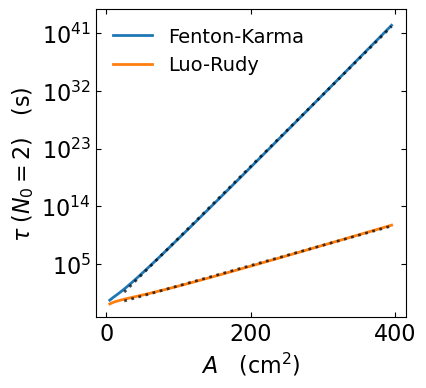

In [144]:
#basic scatter plot of the data at N_0 given
# xlim
figsize=(4,4)
fontsize=16
markersize=10
alpha=1.0
# ylim = (0.0005007487135910895, 5.156057164412211e+44)
# alpha=0.7
fig,ax=plt.subplots(figsize=figsize)
#plot data
# df_tau_fk[df_tau_fk['N0']==N0].plot.scatter(x='A',y='tau',s=markersize,alpha=alpha,ax=ax,label='Fenton-Karma',color='C0')
# df_tau_lr[df_tau_lr['N0']==N0].plot.scatter(x='A',y='tau',s=markersize,alpha=alpha,ax=ax,label='Luo-Rudy',color='C1')
df_tau_fk[df_tau_fk['N0']==N0].plot(x='A',y='tau',alpha=alpha,ax=ax,label='Fenton-Karma',color='C0',lw=2)
df_tau_lr[df_tau_lr['N0']==N0].plot(x='A',y='tau',alpha=alpha,ax=ax,label='Luo-Rudy',color='C1',lw=2)

#plot the fits as dotted lines
# xv,yv=df_tau_fk[df_tau_fk['N0']==N0][['A','tau']].values.T
xv,yv=df_tau_fk[(df_tau_fk['N0']==N0)&(df_tau_fk['A']>=25)][['A','tau']].values.T
B,Delta_B,m,Delta_m,Rsq=fit_exponential(xv,yv)
xvfk=xv.copy()
yvhatfk=np.exp(xv*m+B)
# yvhatfk=-B*np.exp(xv*m)
# yvhatfk=1e-3*np.exp(xv*m)
# yvhatfk=np.exp(xvfk/A0fk-B)
ax.plot(xvfk,yvhatfk,'k:',alpha=0.7,lw=2)


xv,yv=df_tau_lr[(df_tau_lr['N0']==N0)&(df_tau_lr['A']>=25)][['A','tau']].values.T
B,Delta_B,m,Delta_m,Rsq=fit_exponential(xv,yv)
xvlr=xv.copy()
# yvhatlr=np.exp(xv*m-B)
yvhatlr=np.exp(B)*np.exp(xv*m)
ax.plot(xvlr,yvhatlr,'k:',alpha=0.7,lw=2)
    
# format_plot
# format_plot(ax=ax,xlabel=r'$A$   (cm$^2$)',ylabel=r'$\tau(N_0)$   (s)',fontsize=fontsize)
format_plot(ax=ax,xlabel=r'$A$   (cm$^2$)',ylabel=r'$\tau\;$($N_0=$'+f'{N0})   (s)',fontsize=fontsize)
# ax.set_title(model_name,fontsize=fontsize)
ax.set_yscale('log')
# plt.tight_layout()
ax.tick_params(top=True, right=True,direction='in',which='both')
ax.legend(fontsize=fontsize-2,frameon=False,loc='upper left')
ax.set_ylim(ylim)
# ax.set_ylim(xlim)
plt.show()

In [146]:
print(f"\t  *** at {N0=}: ***")
print(f"*** A0: {A0fk:.4f} +/- {Delta_A0fk:.4f} cm^2 (FK) ***")
print(f"*** A0: {A0lr:.4f} +/- {Delta_A0lr:.4f} cm^2 (LR) ***")

	  *** at N0=2: ***
*** A0: 3.8999 +/- 0.1956 cm^2 (FK) ***
*** A0: 13.8252 +/- 1.2413 cm^2 (LR) ***


In [183]:
np.exp(B)

0.03255633400238088

In [191]:
np.linalg.lstsq?